True peak counts (before background subtraction): 17123.0
Total background counts (covering 3 peaks): 24408.0
Average background peak count: 8136.00
Estimated real events (after subtraction): 8987.00


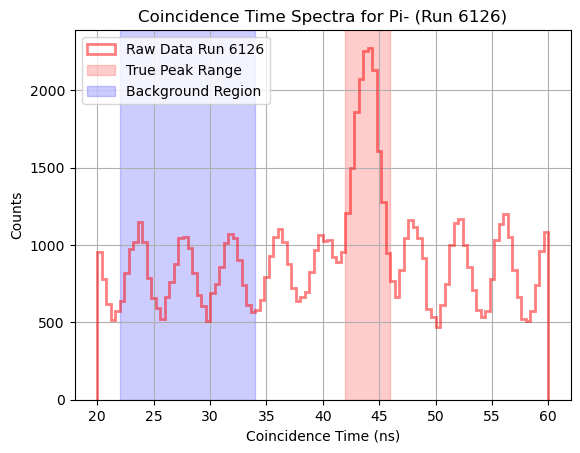

In [14]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

# Define run numbers
run_raw = 6126
run_dummy = 6127

# Toggle to apply pion selection cuts
apply_cuts = True

# File paths
raw_data_path = f'/work/hallc/c-rsidis/gaskelld/example_output/coin_replay_production_{run_raw}_-1.root'
dummy_data_path = f'/work/hallc/c-rsidis/gaskelld/example_output/coin_replay_production_{run_dummy}_-1.root'

# Defining extracted variables
variables = ["P.cal.etottracknorm", "P.hgcer.npeSum", "CTime.ePiCoinTime_ROC1"]

# Function to load data from ROOT files
def load_data(file_path):
    file = uproot.open(file_path)
    tree = file['T']
    return tree.arrays(variables, library="np")

# Load raw and dummy data
data_raw = load_data(raw_data_path)
data_dummy = load_data(dummy_data_path)

# Extract relevant variables
cal_raw, hgcer_raw, coincidence_time_raw = data_raw['P.cal.etottracknorm'], data_raw['P.hgcer.npeSum'], data_raw['CTime.ePiCoinTime_ROC1']
cal_dummy, hgcer_dummy, coincidence_time_dummy = data_dummy['P.cal.etottracknorm'], data_dummy['P.hgcer.npeSum'], data_dummy['CTime.ePiCoinTime_ROC1']

# Define pion selection cuts
def apply_pion_cuts(cal, hgcer, coincidence_time):
    cut = (cal < 0.8) & (hgcer < 1)
    return coincidence_time[cut]

if apply_cuts:
    coincidence_time_raw = apply_pion_cuts(cal_raw, hgcer_raw, coincidence_time_raw)
    coincidence_time_dummy = apply_pion_cuts(cal_dummy, hgcer_dummy, coincidence_time_dummy)

# Define histogram settings
bin_min, bin_max, bin_number = 20, 60, 100
bins = np.linspace(bin_min, bin_max, bin_number + 1)

# Plot raw data histogram
counts_raw, bin_edges, _ = plt.hist(coincidence_time_raw, bins=bins, histtype='step', 
                                    color='red', label=f'Raw Data Run {run_raw}', alpha=0.5, linewidth=2)

# Define analysis time windows
true_peak_range = (42, 46)               # Main signal peak
random_peak_range_combined = (22, 34)    # Combined background region (3 random peaks)

# Function to get indices of bins within a time range
def get_bin_indices(bin_edges, time_range):
    return np.where((bin_edges[:-1] >= time_range[0]) & (bin_edges[:-1] < time_range[1]))[0]

# Get bin indices
true_indices = get_bin_indices(bin_edges, true_peak_range)
random_indices = get_bin_indices(bin_edges, random_peak_range_combined)

# Sum counts
true_counts = np.sum(counts_raw[true_indices])
background_total = np.sum(counts_raw[random_indices])
background_average = background_total / 3  # assuming 3 peaks in the combined region

# Estimate real signal events
real_events = true_counts - background_average

# Print results
print(f"True peak counts (before background subtraction): {true_counts}")
print(f"Total background counts (covering 3 peaks): {background_total}")
print(f"Average background peak count: {background_average:.2f}")
print(f"Estimated real events (after subtraction): {real_events:.2f}")

# Overlay shaded regions on the plot
plt.axvspan(true_peak_range[0], true_peak_range[1], color='red', alpha=0.2, label='True Peak Range')
plt.axvspan(random_peak_range_combined[0], random_peak_range_combined[1], color='blue', alpha=0.2, label='Background Region')

# Customize the plot
plt.xlabel('Coincidence Time (ns)')
plt.ylabel('Counts')
plt.title(f'Coincidence Time Spectra for Pi- (Run {run_raw})')
plt.legend()
plt.grid(True)
plt.show()
